### Initialize Spark Session 

In [1]:
# initialize spark session
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('iteration4').getOrCreate()

### Data Import and Exploration

In [ ]:
# import without schema
df = spark.read.csv('dataset.csv', header=True)

In [ ]:
# data format
from pyspark.sql.types import (StructField, StructType,
                               TimestampType, IntegerType, FloatType)
# define data schema (or use inferSchema =True when loading dataframe)
data_schema = [StructField('instant', IntegerType(), True),
               StructField('dteday', TimestampType(), True),
               StructField('season', IntegerType(), True),
               StructField('yr', IntegerType(), True),
               StructField('mnth', IntegerType(), True),
               StructField('hr', IntegerType(), True),
               StructField('holiday', IntegerType(), True),
               StructField('weekday', IntegerType(), True),
               StructField('workingday', IntegerType(), True),
               StructField('weathersit', IntegerType(), True),
               StructField('temp', FloatType(), True),
               StructField('atemp', FloatType(), True),
               StructField('hum', FloatType(), True),
               StructField('windspeed', FloatType(), True),
               StructField('casual', IntegerType(), True),
               StructField('registered', IntegerType(), True),
               StructField('cnt', IntegerType(), True)]

final_struct = StructType(fields = data_schema)
#import with self-defined schema
df = spark.read.csv('dataset.csv', schema=final_struct, header=True)

In [2]:
# import with inferred schema automatically, only for csv
df = spark.read.csv('dataset.csv', header=True, inferSchema=True)

In [ ]:
#df.show(5) #df.head()
# check features and data type
df.printSchema() #df.columns & df.dtypes
# check number of records
#print('Number of Rows: ', df.count())

In [3]:
# Import the relevant Python libraries.
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
data = df.toPandas()

In [ ]:
sn.boxplot(data['yr'], data['cnt'])
plt.title('the influnce of year')

In [ ]:
sn.pointplot(data['mnth'], data['cnt'])
plt.title('the influnce of month')

Text(0.5,1,'the influnce of hours in a day')

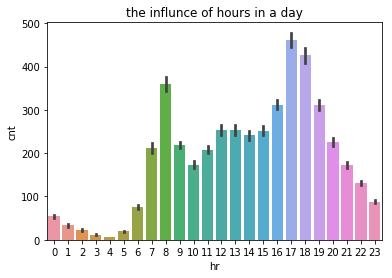

In [22]:
sn.barplot(data['hr'], data['cnt'])
plt.title('the influnce of hours in a day')

In [ ]:
sn.barplot(data['weathersit'], data['cnt'])
plt.title('the influnce of weather')

In [3]:
# data audit
df.describe('instant', 'temp', 'atemp', 'hum', 'cnt').show(1)

+-------+-------+-----+-----+-----+-----+
|summary|instant| temp|atemp|  hum|  cnt|
+-------+-------+-----+-----+-----+-----+
|  count|  13411|16879|16655|16664|17372|
+-------+-------+-----+-----+-----+-----+
only showing top 1 row



### Data Preparation

Text(0.5,1,'rental counts in each weekday')

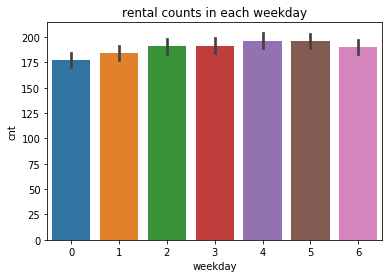

In [4]:
# Data Select
sn.barplot(data['weekday'], data['cnt'])
plt.title('rental counts in each weekday')

In [ ]:
sn.barplot(data['season'], data['cnt'])
plt.title('the influnce of season')

In [4]:
df_selected = df.drop('dteday', 'registered', 'casual', 'season', 'weekday')

In [ ]:
df_selected.printSchema()

In [5]:
# Data Clean
# drop feature 'instant'
df_cleaned = df_selected.drop('instant')
# remove rows where 'cnt' is null
df_cleaned = df_cleaned.na.drop(subset='cnt')

In [ ]:
df_cleaned.show(2)
df_cleaned.describe('cnt').show()
df_cleaned.count()

In [6]:
# fill null values with mean of values in 'temp', 'atemp', 'hum'
from pyspark.sql.functions import mean
mean_temp = df.select(mean(df.temp)).collect()[0][0]
mean_atemp = df.select(mean(df.atemp)).collect()[0][0]
mean_hum = df.select(mean(df.hum)).collect()[0][0]
mean = {'temp': mean_temp, 'atemp': mean_atemp, 'hum': mean_hum}
df_cleaned = df_cleaned.na.fill(mean)

In [7]:
df_cleaned.describe('temp', 'atemp', 'hum', 'cnt').show(1)
df_cleaned.printSchema()

+-------+-----+-----+-----+-----+
|summary| temp|atemp|  hum|  cnt|
+-------+-----+-----+-----+-----+
|  count|17372|17372|17372|17372|
+-------+-----+-----+-----+-----+
only showing top 1 row

root
 |-- yr: integer (nullable = true)
 |-- mnth: integer (nullable = true)
 |-- hr: integer (nullable = true)
 |-- holiday: integer (nullable = true)
 |-- workingday: integer (nullable = true)
 |-- weathersit: integer (nullable = true)
 |-- temp: double (nullable = false)
 |-- atemp: double (nullable = false)
 |-- hum: double (nullable = false)
 |-- windspeed: double (nullable = true)
 |-- cnt: integer (nullable = true)



In [9]:
# Construct Data
from pyspark.ml.feature import OneHotEncoder
# one hot encode: convert numbers into a vector
mnthEncoder = OneHotEncoder(inputCol='mnth', outputCol='mnthVec')
hrEncoder = OneHotEncoder(inputCol='hr', outputCol='hrVec')
weatherEncoder = OneHotEncoder(inputCol='weathersit', outputCol='weatherVec')
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = [hrEncoder, mnthEncoder, weatherEncoder])
df_constructed = pipeline.fit(df_cleaned).transform(df_cleaned)

In [100]:
df_constructed.printSchema()

root
 |-- yr: integer (nullable = true)
 |-- mnth: integer (nullable = true)
 |-- hr: integer (nullable = true)
 |-- holiday: integer (nullable = true)
 |-- workingday: integer (nullable = true)
 |-- weathersit: integer (nullable = true)
 |-- temp: double (nullable = false)
 |-- atemp: double (nullable = false)
 |-- hum: double (nullable = false)
 |-- windspeed: double (nullable = true)
 |-- cnt: integer (nullable = true)
 |-- hrVec: vector (nullable = true)
 |-- mnthVec: vector (nullable = true)
 |-- weatherVec: vector (nullable = true)



### Data Transform

In [10]:
# Reduce the data
df_reduced = df_constructed.drop('mnth', 'hr', 'weathersit')

In [101]:
df_reduced.printSchema()

root
 |-- yr: integer (nullable = true)
 |-- holiday: integer (nullable = true)
 |-- workingday: integer (nullable = true)
 |-- temp: double (nullable = false)
 |-- atemp: double (nullable = false)
 |-- hum: double (nullable = false)
 |-- windspeed: double (nullable = true)
 |-- cnt: integer (nullable = true)
 |-- hrVec: vector (nullable = true)
 |-- mnthVec: vector (nullable = true)
 |-- weatherVec: vector (nullable = true)



In [11]:
# Project the data
# assemble features into a vector for modeling
from pyspark.ml.feature import VectorAssembler
featuresCol = df_reduced.drop('cnt').columns
assembler = VectorAssembler(inputCols = featuresCol, outputCol = 'features')
df_projected = assembler.transform(df_reduced)

In [12]:
final_data = df_projected.select('cnt', 'features')
final_data.show(5)

+---+--------------------+
|cnt|            features|
+---+--------------------+
| 16|(46,[3,4,5,7,31,4...|
| 40|(46,[3,4,5,8,31,4...|
| 32|(46,[3,4,5,9,31,4...|
| 13|(46,[3,4,5,10,31,...|
|  1|(46,[3,4,5,11,31,...|
+---+--------------------+
only showing top 5 rows



### Model Select

In [13]:
from pyspark.ml.regression import (RandomForestRegressor, 
                                   GBTRegressor, 
                                   DecisionTreeRegressor)
# create evaluator with R2
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol='cnt', predictionCol='prediction',
                                metricName='r2')
import numpy as np
import matplotlib.pyplot as plt

In [14]:
#create a sample for model test
sample, x = final_data.randomSplit([0.1, 0.9])

In [ ]:
# fit models with different parameters and evaluate
# random forest regression model with maxDepth: 3, 6, 9,..., 30
r2_rfr = np.zeros(10)
for i in np.arange(10):
    rfr = RandomForestRegressor(labelCol='cnt', maxDepth=(i+1)*3)
    rfrModel = rfr.fit(sample)
    prediction_rfr = rfrModel.transform(sample)
    r2_rfr[i] = evaluator.evaluate(prediction_rfr)
plt.plot(np.arange(3, 33, 3), r2_rfr)
r2_rfr

In [ ]:
# Gradient Boosted Trees model with maxIter: 10, 20, 30,..., 100
r2_gbt = np.zeros(10)
for i in np.arange(10):
    gbt = GBTRegressor(labelCol='cnt', maxIter = (i+1)*10)
    gbtModel = gbt.fit(sample)
    prediction_gbt = gbtModel.transform(sample)
    r2_gbt[i] = evaluator.evaluate(prediction_gbt)
plt.plot(np.arange(10, 105, 10), r2_gbt)
r2_gbt

In [ ]:
# Decision Tree Regression model with maxDepth: 3, 6, 9,..., 30
r2_dtr = np.zeros(10)
for i in np.arange(10):
    dtr = DecisionTreeRegressor(labelCol='cnt', maxDepth= (i+1)*3)
    dtrModel = dtr.fit(sample)
    prediction_dtr = dtrModel.transform(sample)
    r2_dtr[i] = evaluator.evaluate(prediction_dtr)
plt.plot(np.arange(3, 33, 3), r2_dtr)
r2_dtr

### Data Mining

In [15]:
# split data into train and test
train, test = final_data.randomSplit([0.7, 0.3])

In [21]:
#create model
GBT = GBTRegressor(labelCol='cnt', maxIter = 80)
# train the model
GBTmodel = GBT.fit(train)
prediction_GBT = GBTmodel.transform(test)

In [139]:
#show the summary
prediction_GBT.describe().show()

+-------+------------------+------------------+
|summary|               cnt|        prediction|
+-------+------------------+------------------+
|  count|              5215|              5215|
|   mean| 190.4999041227229| 189.9079751686032|
| stddev|181.10015716607145|167.89031165426218|
|    min|                 1|-77.10967793918589|
|    max|               968| 906.5719648570255|
+-------+------------------+------------------+



In [16]:
DTR = DecisionTreeRegressor(labelCol='cnt', maxDepth=20)
DTRmodel = DTR.fit(train)
prediction_DTR = DTRmodel.transform(test)

In [109]:
# show the summary
prediction_DTR.describe().show()

+-------+------------------+------------------+
|summary|               cnt|        prediction|
+-------+------------------+------------------+
|  count|              5215|              5215|
|   mean| 190.4999041227229|190.82029936999675|
| stddev|181.10015716607145|176.26218216968576|
|    min|                 1|               1.0|
|    max|               968|             977.0|
+-------+------------------+------------------+



In [13]:
RFR = RandomForestRegressor(labelCol='cnt', maxDepth=20)
RFRmodel = RFR.fit(train)
prediction_RFR = RFRmodel.transform(test)

In [14]:
# show the summary
prediction_RFR.describe().show()

+-------+------------------+------------------+
|summary|               cnt|        prediction|
+-------+------------------+------------------+
|  count|              5288|              5288|
|   mean|191.91509077155825| 192.5416922123185|
| stddev|184.23537222941195| 164.7192362503229|
|    min|                 1|2.6356823510388874|
|    max|               977| 923.4961038961037|
+-------+------------------+------------------+



In [125]:
# search for patterns
print(DTRmodel.toDebugString)

DecisionTreeRegressionModel (uid=DecisionTreeRegressor_4afb8dc024bfa2e13546) of depth 20 with 10419 nodes
  If (feature 4 <= 0.5909)
   If (feature 15 in {0.0})
    If (feature 24 in {0.0})
     If (feature 25 in {0.0})
      If (feature 3 <= 0.28)
       If (feature 16 in {0.0})
        If (feature 14 in {0.0})
         If (feature 26 in {0.0})
          If (feature 17 in {0.0})
           If (feature 19 in {0.0})
            If (feature 5 <= 0.45)
             If (feature 0 <= 0.0)
              If (feature 8 in {1.0})
               If (feature 2 <= 0.0)
                If (feature 3 <= 0.16)
                 Predict: 12.0
                Else (feature 3 > 0.16)
                 Predict: 16.0
               Else (feature 2 > 0.0)
                If (feature 31 in {1.0})
                 If (feature 3 <= 0.16)
                  Predict: 1.0
                 Else (feature 3 > 0.16)
                  Predict: 2.0
                Else (feature 31 not in {1.0})
                 If (featu

In [29]:
# search for patterns
print(RFRmodel.toDebugString)

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/home/ubuntu/spark-2.1.1-bin-hadoop2.7/python/lib/py4j-0.10.4-src.zip/py4j/java_gateway.py", line 1035, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ubuntu/spark-2.1.1-bin-hadoop2.7/python/lib/py4j-0.10.4-src.zip/py4j/java_gateway.py", line 883, in send_command
    response = connection.send_command(command)
  File "/home/ubuntu/spark-2.1.1-bin-hadoop2.7/python/lib/py4j-0.10.4-src.zip/py4j/java_gateway.py", line 1040, in send_command
    "Error while receiving", e, proto.ERROR_ON_RECEIVE)
py4j.protocol.Py4JNetworkError: Error while receiving


Py4JError: An error occurred while calling o201.toDebugString

In [23]:
# search for patterns
print(GBTmodel.toDebugString)

GBTRegressionModel (uid=GBTRegressor_4aaa9f280c2def275693) with 80 trees
  Tree 0 (weight 1.0):
    If (feature 4 <= 0.5909)
     If (feature 15 in {0.0})
      If (feature 24 in {0.0})
       If (feature 25 in {0.0})
        If (feature 3 <= 0.3)
         Predict: 67.82457002457002
        Else (feature 3 > 0.3)
         Predict: 137.0321701199564
       Else (feature 25 not in {0.0})
        If (feature 3 <= 0.49789324012086394)
         Predict: 252.6818181818182
        Else (feature 3 > 0.49789324012086394)
         Predict: 489.1392405063291
      Else (feature 24 not in {0.0})
       If (feature 4 <= 0.3182)
        If (feature 2 <= 0.0)
         Predict: 119.97142857142858
        Else (feature 2 > 0.0)
         Predict: 244.76470588235293
       Else (feature 4 > 0.3182)
        If (feature 0 <= 0.0)
         Predict: 314.67619047619047
        Else (feature 0 > 0.0)
         Predict: 516.5192307692307
     Else (feature 15 not in {0.0})
      If (feature 2 <= 0.0)
       If (

In [17]:
DTRmodel.featureImportances

SparseVector(46, {0: 0.0719, 1: 0.0008, 2: 0.0791, 3: 0.0567, 4: 0.2049, 5: 0.085, 6: 0.023, 7: 0.0189, 8: 0.0094, 9: 0.0124, 10: 0.0119, 11: 0.0148, 12: 0.016, 13: 0.0093, 14: 0.0157, 15: 0.0655, 16: 0.006, 17: 0.0024, 18: 0.005, 19: 0.0053, 20: 0.006, 21: 0.0013, 22: 0.0031, 23: 0.0151, 24: 0.0791, 25: 0.0805, 26: 0.0287, 27: 0.0089, 28: 0.0003, 29: 0.0061, 31: 0.0003, 32: 0.0014, 33: 0.0002, 34: 0.0039, 35: 0.0053, 36: 0.0047, 37: 0.0044, 38: 0.0013, 39: 0.001, 40: 0.0139, 41: 0.0017, 43: 0.0048, 44: 0.0008, 45: 0.0131})

In [15]:
RFRmodel.featureImportances

SparseVector(46, {0: 0.0705, 1: 0.0022, 2: 0.0842, 3: 0.1028, 4: 0.1304, 5: 0.0917, 6: 0.0185, 7: 0.0212, 8: 0.0162, 9: 0.0185, 10: 0.0294, 11: 0.0269, 12: 0.0214, 13: 0.0067, 14: 0.011, 15: 0.061, 16: 0.0075, 17: 0.0024, 18: 0.0026, 19: 0.0033, 20: 0.0032, 21: 0.0026, 22: 0.0032, 23: 0.0112, 24: 0.099, 25: 0.0692, 26: 0.0233, 27: 0.0063, 28: 0.0018, 29: 0.0036, 31: 0.0029, 32: 0.0023, 33: 0.0029, 34: 0.0023, 35: 0.0019, 36: 0.0017, 37: 0.0037, 38: 0.0015, 39: 0.0041, 40: 0.0042, 41: 0.0033, 43: 0.0044, 44: 0.0034, 45: 0.0094})

In [25]:
GBTmodel.featureImportances

SparseVector(46, {0: 0.0747, 1: 0.0109, 2: 0.2143, 3: 0.0835, 4: 0.1224, 5: 0.0721, 6: 0.0306, 7: 0.0124, 8: 0.0122, 9: 0.0152, 10: 0.0153, 11: 0.0161, 12: 0.0125, 13: 0.0071, 14: 0.0124, 15: 0.0334, 16: 0.0117, 17: 0.0107, 18: 0.0089, 19: 0.0129, 20: 0.0112, 21: 0.0111, 22: 0.0123, 23: 0.0182, 24: 0.0171, 25: 0.023, 26: 0.0196, 27: 0.0112, 28: 0.0074, 29: 0.0029, 31: 0.0079, 32: 0.0089, 33: 0.0081, 34: 0.0046, 35: 0.0016, 36: 0.0005, 37: 0.002, 38: 0.0039, 39: 0.0061, 40: 0.0076, 41: 0.0059, 43: 0.0034, 44: 0.0006, 45: 0.0156})

In [18]:
# before vector assemble
df_reduced.show(5)

+---+-------+----------+----+------------------+------------------+---------+---+--------------+--------------+-------------+
| yr|holiday|workingday|temp|             atemp|               hum|windspeed|cnt|         hrVec|       mnthVec|   weatherVec|
+---+-------+----------+----+------------------+------------------+---------+---+--------------+--------------+-------------+
|  0|      0|         0|0.24|            0.2879|              0.81|      0.0| 16|(23,[0],[1.0])|(12,[1],[1.0])|(4,[1],[1.0])|
|  0|      0|         0|0.22|0.4771872830981645|               0.8|      0.0| 40|(23,[1],[1.0])|(12,[1],[1.0])|(4,[1],[1.0])|
|  0|      0|         0|0.22|            0.2727|0.6233845415266452|      0.0| 32|(23,[2],[1.0])|(12,[1],[1.0])|(4,[1],[1.0])|
|  0|      0|         0|0.24|            0.2879|              0.75|      0.0| 13|(23,[3],[1.0])|(12,[1],[1.0])|(4,[1],[1.0])|
|  0|      0|         0|0.24|            0.2879|              0.75|      0.0|  1|(23,[4],[1.0])|(12,[1],[1.0])|(4,[1],

In [24]:
# after vector assemble
df_projected.select('features').collect()[0:5]

[Row(features=SparseVector(46, {3: 0.24, 4: 0.2879, 5: 0.81, 7: 1.0, 31: 1.0, 43: 1.0})),
 Row(features=SparseVector(46, {3: 0.22, 4: 0.4772, 5: 0.8, 8: 1.0, 31: 1.0, 43: 1.0})),
 Row(features=SparseVector(46, {3: 0.22, 4: 0.2727, 5: 0.6234, 9: 1.0, 31: 1.0, 43: 1.0})),
 Row(features=SparseVector(46, {3: 0.24, 4: 0.2879, 5: 0.75, 10: 1.0, 31: 1.0, 43: 1.0})),
 Row(features=SparseVector(46, {3: 0.24, 4: 0.2879, 5: 0.75, 11: 1.0, 31: 1.0, 43: 1.0}))]

### Interpretation

In [ ]:
# study
# Working or Not
axes = plt.subplots(2, 1, figsize = (16,10))
ax1 = plt.subplot(2, 1, 1)
sn.pointplot(data['hr'], data['cnt'], hue=data['workingday'], ax=ax1)
ax1.set_title('the influnce of hour in workingday')
ax2 = plt.subplot(2, 2, 3)
sn.pointplot(data['hr'], data['cnt'], hue=data['holiday'], ax=ax2)
ax2.set_title('the influnce of hour in holiday')
ax3 = plt.subplot(2, 2, 4)
sn.pointplot(data['hr'], data['cnt'], hue=data['weekday'], ax=ax3)
ax3.set_title('the influnce of hour in weekday')

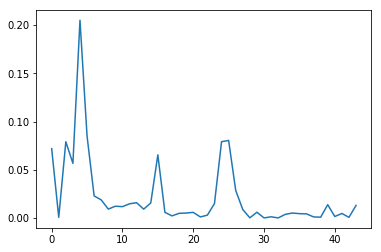

In [20]:
#virsualize
plt.plot(DTRmodel.featureImportances.values)

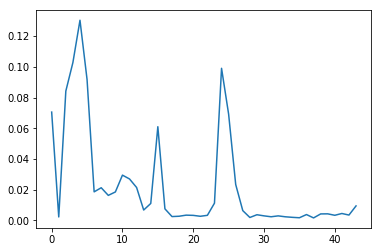

In [17]:
#virsualize
plt.plot(RFRmodel.featureImportances.values)

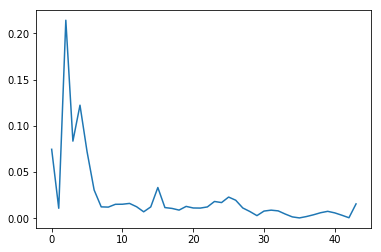

In [26]:
#virsualize
plt.plot(GBTmodel.featureImportances.values)

In [19]:
#virsualize
features = ('year', 'hday', 'wday', 'temp', 'atemp', 'hum', 'wind',
            'hr','hr','hr','hr','hr','hr','hr','hr','hr','hr','hr','hr',
            'hr','hr','hr','hr','hr','hr','hr','hr','hr','hr', 'hr',
            'mnth','mnth', 'mnth', 'mnth', 'mnth', 'mnth', 'mnth','mnth', 
            'mnth','mnth', 'mnth', 'mnth', 'wsit', 'wsit', 'wsit', 'wsit')

<BarContainer object of 46 artists>

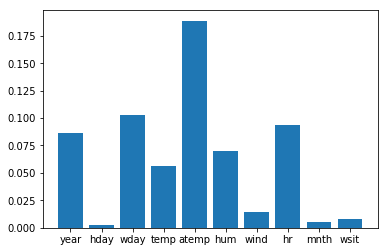

In [137]:
# group the features and visualization:
plt.bar(features ,DTRmodel.featureImportances)

<BarContainer object of 46 artists>

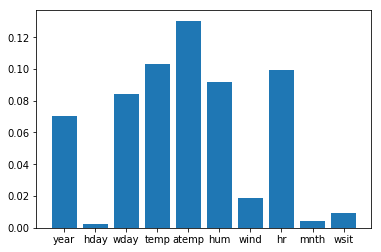

In [20]:
# group the features and visualization:
plt.bar(features ,RFRmodel.featureImportances)

<BarContainer object of 46 artists>

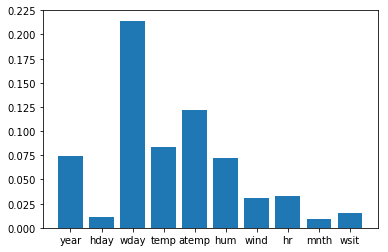

In [27]:
# group the features and visualization:
plt.bar(features ,GBTmodel.featureImportances)

In [ ]:
# Interpret
# Registered or Casual
axes = plt.subplots(2, 1, figsize = (16,10))
ax1 = plt.subplot(2, 1, 1)
sn.pointplot(data['hr'], data['registered'], ax=ax1)
ax1.set_title('registered rental counts in a day')
ax2 = plt.subplot(2, 1, 2)
sn.pointplot(data['hr'], data['casual'], ax=ax2)
ax2.set_title('casual rental counts in a day')

In [28]:
#evaluate model
r2_GBT = evaluator.evaluate(prediction_GBT)
r2_DTR = evaluator.evaluate(prediction_DTR)
r2_RFR = evaluator.evaluate(prediction_RFR)
print('R2 Score of GBT Regression: ', r2_GBT)
print('R2 Score of Decision Tree Regression: ', r2_DTR)
print('R2 Score of Random Forest Regression: ', r2_RFR)

R2 Score of GBT Regression:  0.8879642587782158
R2 Score of Decision Tree Regression:  0.8093381583955093
R2 Score of Random Forest Regression:  0.8708575498574057
